In [1]:
import cairo
import cv2
import numpy as np
from math import *
from itertools import groupby
from IPython.display import SVG, Image, display
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Code for fiducial image generation
def topoToGeom(topo):
    l = len(topo)
    if l == 0:
        return (0,0,10,[])
    # each level is layed out as a circle
    a = 2 * pi / len(topo)
    # a circle is (x,y,r,[subcircles])
    cs = [topoToGeom(t) for t in topo]
    mr = max([maxr(c) for c in cs])
    # mr = r * sin(a/2)
    r = mr / sin(a/2) + 5
    ts = []
    for i in range(l):
        t = translate(r*cos(i*a), r*sin(i*a),cs[i])
        ts.append(t)
    return (0,0,r+mr+5,ts)

def maxr(c):
    (x,y,r,cs) = c
    return max([sqrt(x*x+y*y) + r, max([0] + [maxr(s) for s in cs])])

def translate(dx, dy, v):
    (x,y,r,cs) = v
    return (x+dx,y+dy,r,[translate(dx,dy,c) for c in cs])

def circle(context, c, colors, i):
    (x,y,r,cs) = c
    #print(x,y,r, colors[i % len(colors)])
    context.arc(x,y,r,0,2*pi)
    context.set_source_rgba(*(colors[i % len(colors)]))
    context.fill()
    for s in cs:
        circle(context, s, colors, i+1)
    
def buildWithTopo(context, x, y, topo):
    c = translate(x,y,topoToGeom(topo))
    circle(context, c, [[0,0,0,1],[1,1,1,1]], 0)
    #circle(context, c, [[1,0,0,0]], 0)

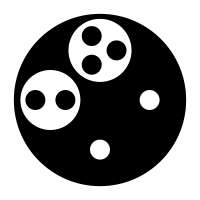

In [3]:
with cairo.SVGSurface("test.svg", 200, 200) as surface:
    context = cairo.Context(surface)
    buildWithTopo(context, 100, 100, [[],[],[[],[]],[[],[],[]]])

SVG("test.svg")

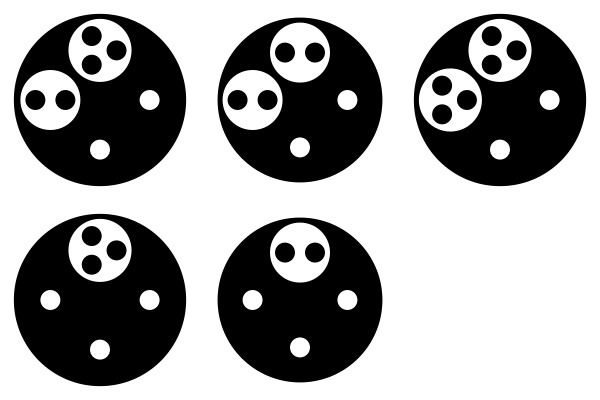

In [4]:
with cairo.SVGSurface("test2.svg", 600, 400) as surface:
    context = cairo.Context(surface)
    buildWithTopo(context, 100, 100, [[],[],[[],[]],[[],[],[]]])
    buildWithTopo(context, 300, 100, [[],[],[[],[]],[[],[]]])
    buildWithTopo(context, 500, 100, [[],[],[[],[],[]],[[],[],[]]])
    
    buildWithTopo(context, 100, 300, [[],[],[],[[],[],[]]])
    buildWithTopo(context, 300, 300, [[],[],[],[[],[]]])
    
SVG("test2.svg")

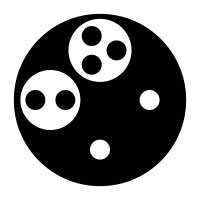

In [5]:
with cairo.ImageSurface(cairo.FORMAT_ARGB32, 200, 200) as surface:
    context = cairo.Context(surface)
    context.set_source_rgb(1,1,1)
    context.paint()
    buildWithTopo(context, 100, 100, [[],[],[[],[]],[[],[],[]]])
    surface.write_to_png("test.png")

Image("test.png")

In [6]:
# Here is code for finding the fiducials.
def contourDepth(hs, ic):
    """
    Given a hierarchy `hs` and an index to one of its contours `ic`,
    find the length of the chain of parents.    
    """
    p = hs[0,ic,3]
    d = 0
    while p != -1:
        p = hs[0,p,3]
        d += 1
    return d

def children(hs, ic):
    """
    Given a hierarch `hs` and an index to one of its contours `ic`,
    yield all of its child indices.
    """
    child = hs[0,ic,2]
    while child != -1:
        yield child
        child = hs[0,child,0]

def leaves(hs, ic, depth = 0):
    """
    Given a hierarch `hs` and an index to one of its contours `ic`,
    find all the leaves and label them with their depth.
    """
    child = hs[0,ic,2]
    if child == -1: # if `ic` is a leaf
        return [(ic,depth)]
    ls = []
    while child != -1:
        ls = ls + leaves(hs, child, depth+1)
        child = hs[0,child,0]
    return ls

def mean(cs, ic):
    """
    Given the contours `cs` and an index to one `ic`,
    return the center of the contour.
    """
    M = cv2.moments(cs[ic])
    cx = M['m10']/M['m00']
    cy = M['m01']/M['m00']
    return [cx,cy]

def hierarchyToTopo(hs, start = -1):
    """
    Given a hierarch `hs`, convert it to
    a sorted list of lists of ... topology (canonical form).
    """
    def helper(p):
        cs = children(hs, p)
        ts = []
        for c in cs:
            ts.append(helper(c))
        return ts
    ls = list(sorted(helper(start)))
    while len(ls) == 1:
        ls = ls[0]
    return ls

# All the fiducials we can recognize.
fiducials = {
    str([[],[],[[],[]],[[],[],[]]]) : "A",
    str([[],[],[[],[]],[[],[]]]) : "B",
    str([[],[],[[],[],[]],[[],[],[]]]) : "C",
    str([[],[],[],[[],[],[]]]) : "D",
    str([[],[],[],[[],[]]]) : "E",
}

def findFiducials(hs):
    """
    Given a hierarch `hs`, find all the fiducials we can recognize.
    """
    for i in range(hs.shape[1]):
        t = hierarchyToTopo(hs, i)
        if str(t) in fiducials:
            f = fiducials[str(t)]
            yield (i,f)

def fiducialLinesAndLabels(hs,cs,fs):
    """
    Given a hierarch `hs`, its contours `cs`, and the found fiducials `fs`,
    compute lines and labels.
    """
    lines = []
    labels = []
    for n,gs in [(f[1], groupby(leaves(hs,f[0],0), key=lambda x: x[1])) for f in fs]:
        poly = np.array([np.average(np.array([mean(cs, l[0]) for l in ls[1]]),axis=0) for ls in gs], np.int32)
        labels.append((poly[0,:], n))
        poly = poly.reshape((-1,1,2))
        lines.append(poly)
    return lines,labels

def drawFiducials(img, lines, labels):
    """
    Given an image `img`, `lines` to draw, and coordinate-label pairs `labels`,
    draw the lines and labels on `img`.
    """
    cv2.polylines(img, lines, False, (0,255,255))
    font = cv2.FONT_HERSHEY_SIMPLEX
    for v,t in labels:
        cv2.putText(img, t, (v[0],v[1]), font, 1, (255,0,255), 2, cv2.LINE_AA)

In [7]:
# Here is code for finding the contours
def findFiducialContours(img, blurWidth=5, threshold="OTSU", showSteps=True):
    """
    Test visualization for getting good parameters for the preparation to find contours.
    """
    if showSteps: plt.title("Original"), plt.imshow(img), plt.show()
    
    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if showSteps: plt.title("Gray"), plt.imshow(gray),  plt.show()
    
    # blur
    blur = cv2.GaussianBlur(gray,(blurWidth,blurWidth),0)
    if showSteps: plt.title("blur"), plt.imshow(blur), plt.show()
    
    # Threshold
    if threshold == "BINARY":
        _,thresh = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY)
    elif threshold == "OTSU":
        _,thresh = cv2.threshold(blur,0,255,cv2.THRESH_OTSU)
    elif threshold == "ADAPTIVE":
        thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,151,2)
    else:
        assert False, "Threshold must be BINARY, OTSU, or ADAPTIVE."
    if showSteps: plt.title("Thresh " + threshold), plt.imshow(thresh), plt.show()
    
    # Find Contours
    _, cs, hs = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if showSteps:
        colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255)]
        img2 = img.copy()
        for ic in range(len(cs)):
            d = contourDepth(hs, ic)
            c = colors[d % len(colors)]
            cv2.drawContours(img2, cs, ic, c, 3)
        plt.title("Contours"), plt.imshow(img2), plt.show()
    
    return cs,hs

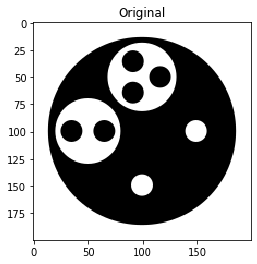

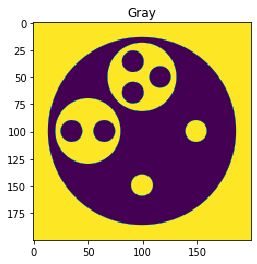

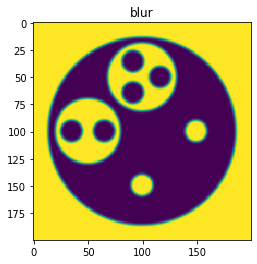

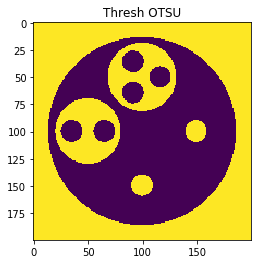

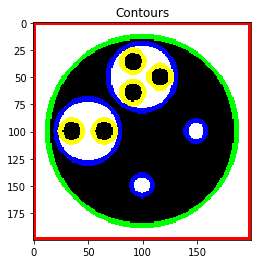

In [8]:
# Testing contour finding on an ideal image.
img = cv2.imread("test.png")
cs,hs = findFiducialContours(img)

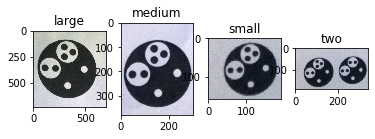

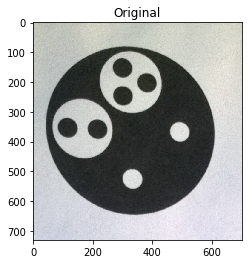

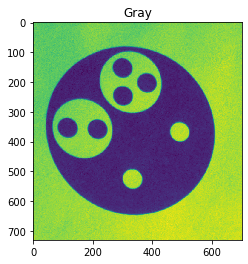

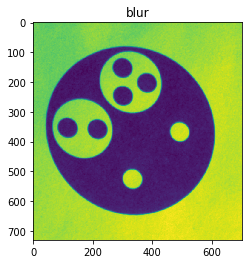

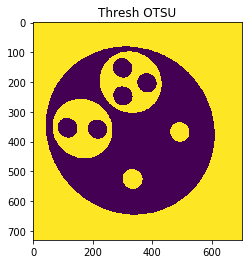

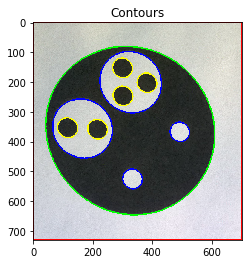

In [9]:
# Here are some experiments on a real-world test images
img = cv2.imread("sheet.jpg")
cropLarge = img[250:980,250:950] # one of the large fiducials
plt.subplot(141), plt.title("large"), plt.imshow(cropLarge)
cropMedium = img[1550:1930,450:750] # one of the large fiducials
plt.subplot(142), plt.title("medium"), plt.imshow(cropMedium)
cropSmall = img[2250:2410,500:690] # one of the large fiducials
plt.subplot(143), plt.title("small"), plt.imshow(cropSmall)
cropTwo = img[2220:2410,500:840] # one of the large fiducials
plt.subplot(144), plt.title("two"), plt.imshow(cropTwo)
plt.show()
cs,hs = findFiducialContours(cropLarge)
#cs,hs = findFiducialContours(cropMedium)
#cs,hs = findFiducialContours(cropSmall)
#cs,hs = findFiducialContours(cropTwo)
#cs,hs = findFiducialContours(img)